# Classifying Philosophical Texts

This notebook is a part of work being done for the [Trace of Theory project](https://github.com/htrc/ACS-TT), a collaboration between researchers of [NovelTM](http://novel-tm.ca/) and the HathiTrust Research Center ([HTRC](https://www.hathitrust.org/)). In particular, we are wanting to use both [supervised](https://en.wikipedia.org/wiki/Supervised_learning) and [unsupervised](https://en.wikipedia.org/wiki/Unsupervised_learning) machine learning techniques on HTRC texts to gain a better understanding of the extent and nature of theory in various genres.

In this notebook we experiment with classifying philosophical texts, based on a small sample of [40 texts](https://github.com/htrc/ACS-TT/tree/master/data/philosophy/texts) compiled by Geoffrey & Co., half of which are identified (by their filename prefix) as being "Philosophical" and the other half as being "Other".

In these experiments, we will explore the following techniques:

* [document similarity](#Document-Similarity)
* [supervised classification](#Supervised-Classification)

## Document Similarity

This notebook is ostensibly about classification of documents, but before we get there it will be helpful to better understand the nature of the corpus, and to do that we'll first make a detour to look at document similarity. In other words, before we start to ask the machine to guess at what texts are philosophical or not, it's worth trying to see if the texts cluster naturally, without any machine learning. The following section draws in part on the [Document Similarity](https://github.com/sgsinclair/alta/blob/master/ipynb/DocumentSimilarity.ipynb) notebook from the Art of [Literary Text Analysis](https://render.githubusercontent.com/view/ArtOfLiteraryTextAnalysis.ipynb) where some of the concepts and techniques are explained more fully.

We can measure document similarity in a variety of ways but for our purposes here we'll consider relative frequencies, that is, the frequency of each word in a document with respect to the total number of words in that document (a [previous version](https://github.com/htrc/ACS-TT/blob/73827a7b5a4ba22ac26261d584d742004ff01b40/tools/notebooks/ClassifyingPhilosophicalText.ipynb) of this notebook used [TF-IDF](http://en.wikipedia.org/wiki/Tf%E2%80%93idf) which better at indicating the significance of the term frequency within the corpus, but this technique scales less well for dynamic and large corpora since we need to know in advance how many documents contain a given term). To grossly over-simplify, we build a matrix of relative frequency values for each term (let's call those the columns) in each document (let's call those the rows). We end up with a massive table of data, and we'll consider two ways of visualizing the document clusters that can be found in the matrix (documents with more or less similar relative frequency values).

Below is a longer chunk of (mostly unexplained) code that essentially produces two visualizations for document similarity:

* a dendrogram that shows a cluster hierarchy of documents
* a colour-coded scatterplot that shows the multidimensional term frequencies matrix in a 2D space (suggesting clusters)

In [1]:
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.manifold import MDS
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import ward, dendrogram
%matplotlib inline

# plot the documents from the corpus
def plot_corpus_similarity(corpus, vectorizer):
    
    # generate the vector, distances and positions
    texts = [corpus.raw(fileid) for fileid in corpus.fileids()]
    documentTermMatrix = vectorizer.fit_transform(texts)
    distances = 1 - cosine_similarity(documentTermMatrix)
    mds = MDS(dissimilarity="precomputed", random_state=1)
    positions = mds.fit_transform(distances)
    
    # plot dendrogram
    linkage_matrix = ward(distances)
    plt.figure(figsize=(8,10))
    dendrogram(linkage_matrix, labels=corpus.fileids(), orientation="right");
    plt.show()  # fixes margins
    
    # plot scatter
    xvalues = positions[:, 0] 
    yvalues = positions[: ,1] 
    plt.figure(figsize=(20,10))
    for x, y, name in zip(xvalues, yvalues, corpus.fileids()):
        plt.scatter(x, y)
        # the colour-coding here is a bit of a hard-coded hack for what is otherwise mostly reusable code
        plt.text(x, y, name.replace(".txt", "")[:25], color='red' if 'Other' in name else 'green')
    plt.show()

### Simple Document Similarities

We'll begin by loading our corpus into an NLTK corpus for convenience (all the plain text files in the data/philosophy/texts directory of the repository).

In [3]:
import nltk
from nltk.corpus.reader.plaintext import PlaintextCorpusReader

data_dir = "."
corpus = PlaintextCorpusReader(data_dir+"/texts", ".*\.txt")

Now that we have a corpus, we can try out the functions above by sending our entire corpus with a simple tokenizer that doesn't include stopwords or keywords to keep. Notice that we use a [TF-IDF vectorizer](http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html) but we tell the vectorizer to not compute the document frequencies (``use_idf=False``) which simply normalizes (relativizes) the term frequencies by document.

/Users/mwilkens/anaconda/lib/python3.4/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


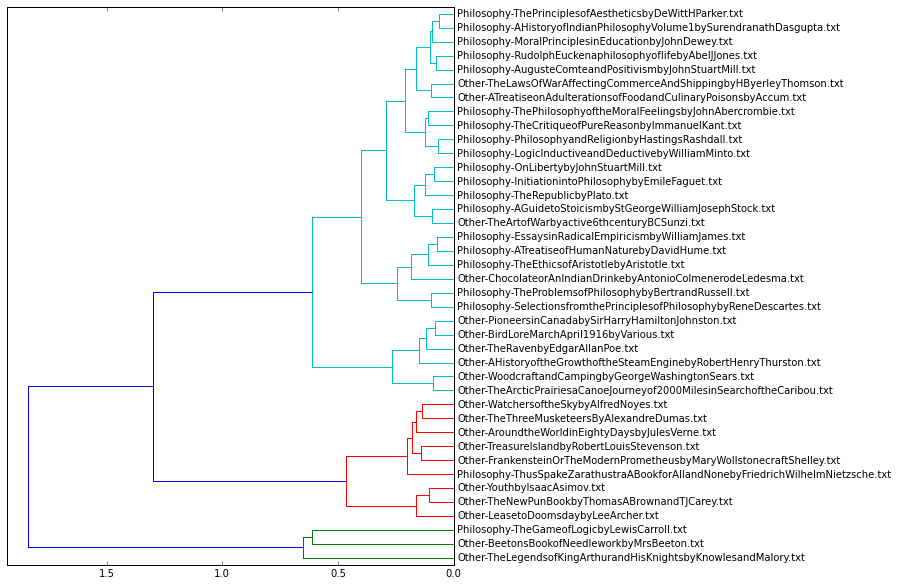

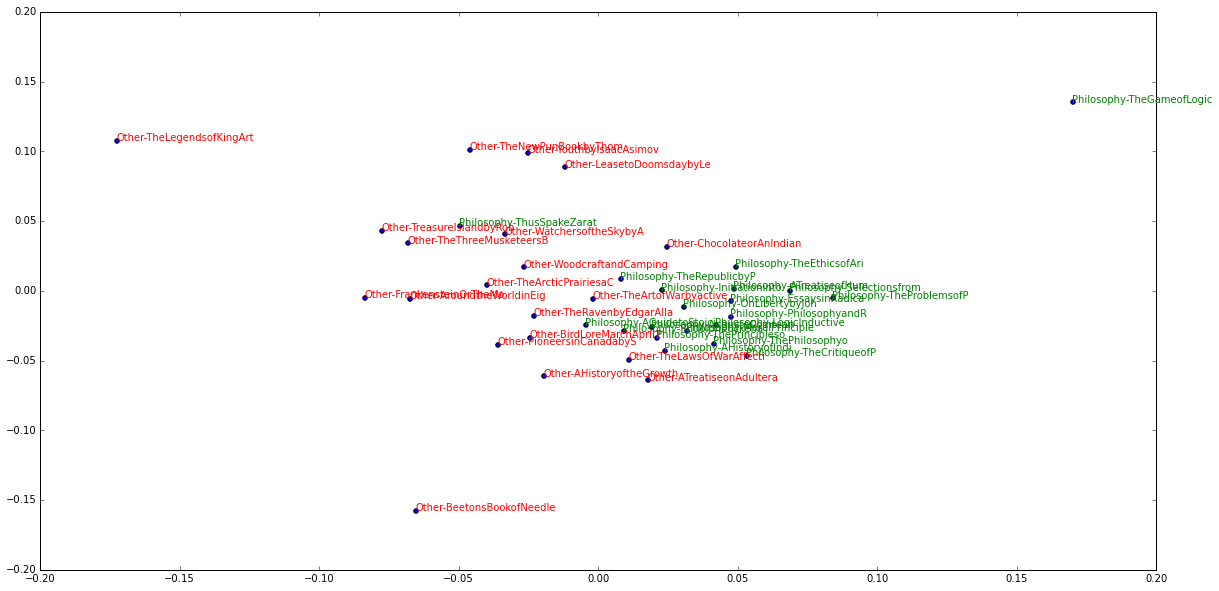

In [4]:
simple_vectorizer = TfidfVectorizer(use_idf=False)
plot_corpus_similarity(corpus, simple_vectorizer)

We see that the documents cluster fairly well in both graphs.

The scatterplot (lower graph) shows _GameofLogic_ and to a lesser extent _ThusSpakeZarathustra_ as outliers to the philosophical cluster (in green). It also shows that the "Other" documents (in red) are much more diffuse that the Philsophical cluster (not surprisingly since the "Other" corpus includes multiples genres.

### Simple Document Similarities with Stopwords

Let's repeat the experience now using English stopwords – this will remove common function words from the relative term frequencies matrix. We'll also limit the number of terms considered to 5,000 for further efficiency.

/Users/mwilkens/anaconda/lib/python3.4/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


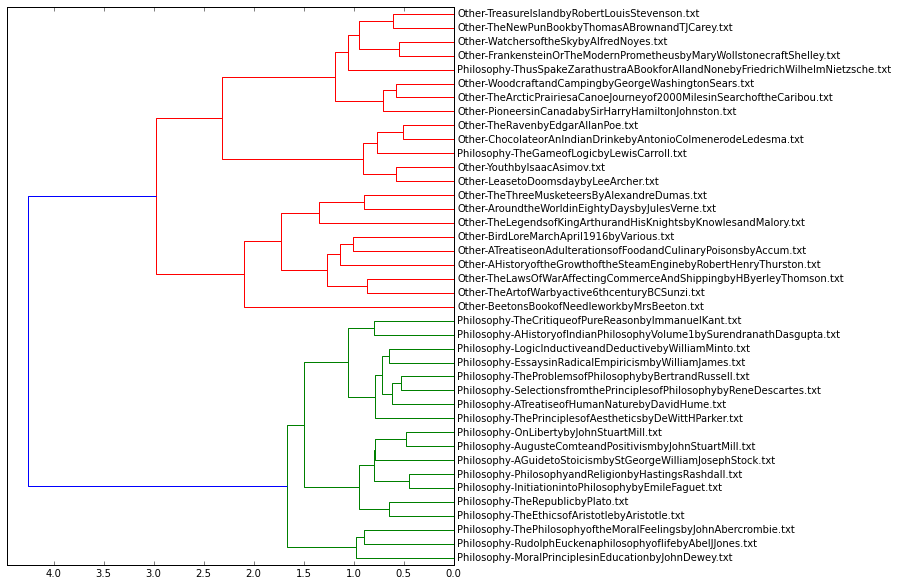

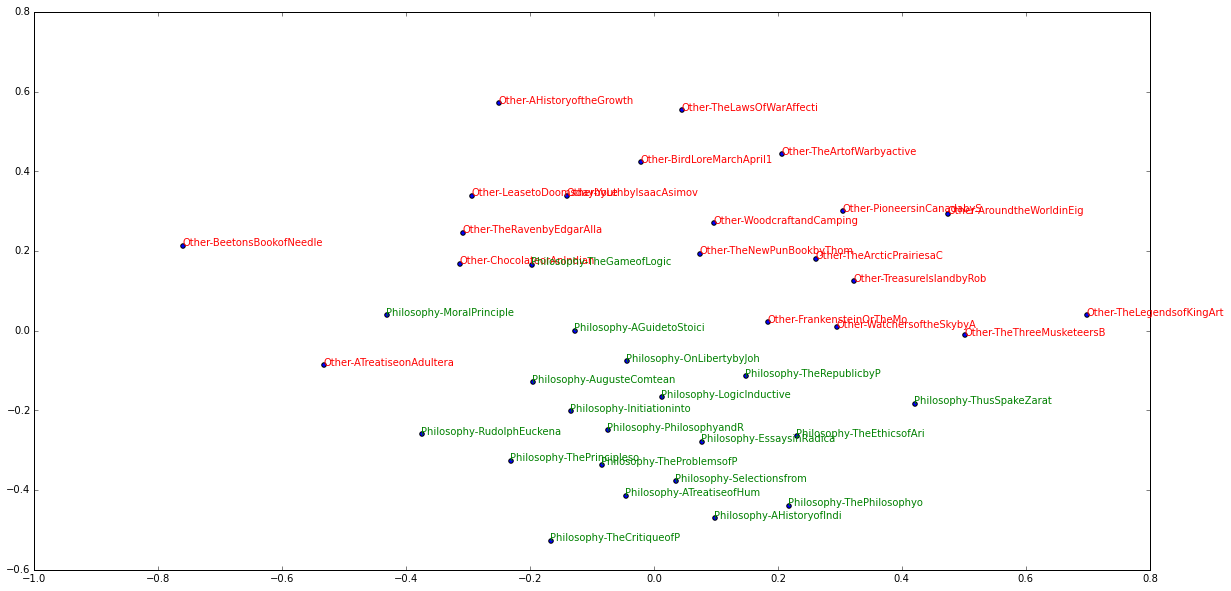

In [5]:
stoplist_vectorizer = TfidfVectorizer(use_idf=False, stop_words=nltk.corpus.stopwords.words("english"), max_features=5000)
plot_corpus_similarity(corpus, stoplist_vectorizer)

These new graphs with stopwords show some differences. In the dendrogram there's a much better clustering of the Philosophical and Other texts. _ThusSpakeZarathustra_ and _GameofLogic_ are philosophical texts that venture into "Other" territory. More significant perhaps is the nice hiearchical cluster of green and red bars that neatly separates between "Other" and "Philosophical".

Likewise, the scatterplot suggests the same outliers, but what's really different is that there aren't huge outliers like before (in the previous set of graphs where _GameOfLogic_, _Beetons_, _Legends_ are clearly outliers), which provides a more detailed view of the condensed clusters.

### Simple Document Similarities with Philosophical Keywords

Rather than exclude certain words as we've done with the English stopwords, we can also run the same process by only including certain (philosophical) words. We have a list of [philosophical keywords](https://github.com/htrc/ACS-TT/blob/master/data/philosophy/keywords.txt) developed by Geoffrey & Co. that we can use.

/Users/mwilkens/anaconda/lib/python3.4/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


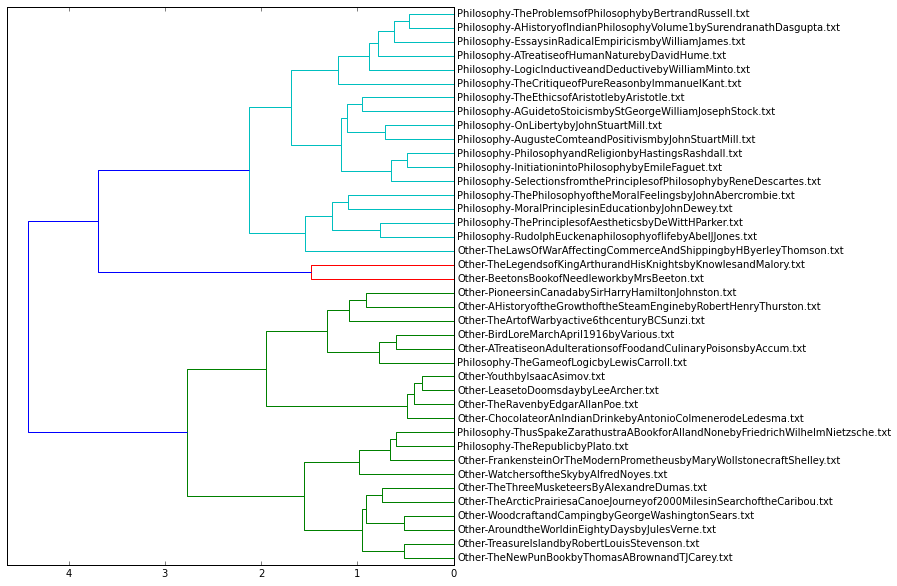

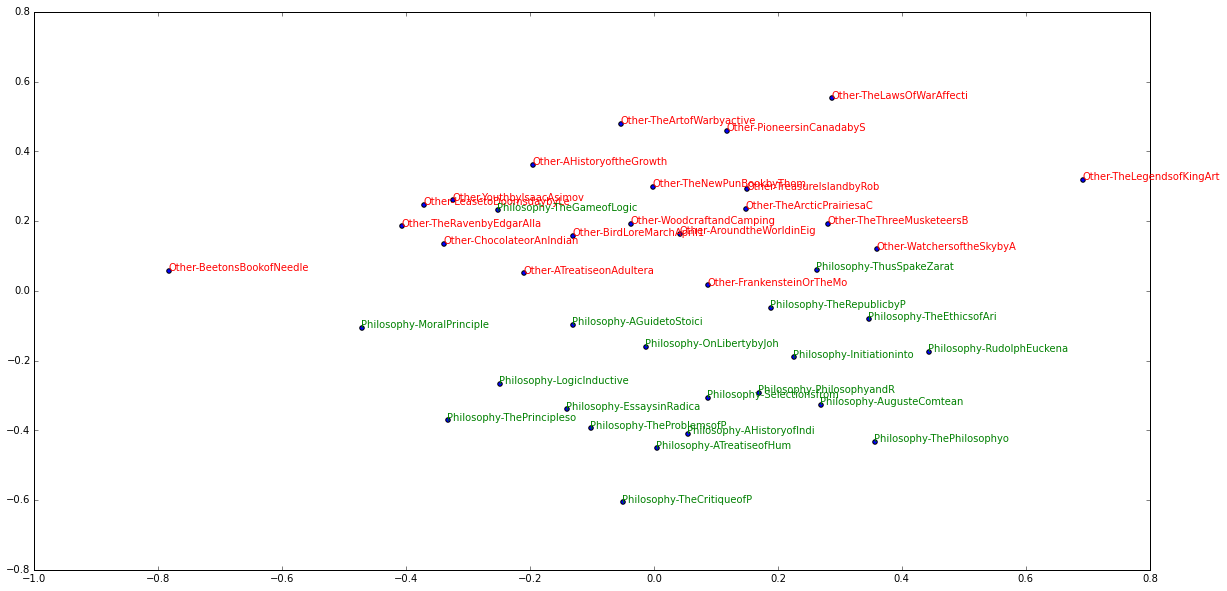

In [7]:
keywords = [line.rstrip('\n') for line in open(data_dir+'/keywords.txt')]
keywords_vectorizer = TfidfVectorizer(use_idf=False, vocabulary=keywords)
plot_corpus_similarity(corpus, keywords_vectorizer)

Again, the clustering is fairly good, but the dendrogram isn't as cleanly clustered as our run with all except stopwords. There's a good sequence of Philosohpical texts, but then there's more messiness in the bottom part of the dendrogram.

### Document Similarities Summary

The major take-aways from this exploratory work with document similarities are:

* the texts cluster fairly well by category ("philosophical", "other")
* _ThusSpakeZarathustra_ and _GameofLogic_ seem to be outliers in the philosophical cluster
* the best clustering seem to happen when including stopwords but not keywords

## Supervised Classification

[Supervised classification](https://en.wikipedia.org/wiki/Supervised_learning) is essentially a process where we help the computer understand how known items (like texts) are classified in a training set, and then the computer tries to help us by classifying items it hasn't seen before. To determine the accuracy of a classifier, we can use a subset of our known items for training purposes and then test against another subset of our known items to see how many are correctly classified.

## Comparing Classifiers

In our case we have a total of known 40 texts, half of which are labelled as "Philosophy" and half of which are labelled as "Other". We can load all of our texts, randomized the order, and use half for training and half for testing (this ratio is maybe a bit unconventional because we have so few texts in our corpus, typically people use more of an 80/20 split between training and test sets).

There are many classifiers available and each one has parameters that can be tweaked. Which classifier and which parameters to use depend a lot on the data, the saying goes, but that's not very useful for us if we're just wanting to pick up a classifier and choose some settings. So let's begin by creating an algorithm to compare the accuracy of the classifiers.

Given a set of texts, we will:

* shuffle the order randomly
* choose half as training data and the other half as test data
* create, train and test 13 classifiers (vaguely based on [this example](http://scikit-learn.org/stable/auto_examples/text/document_classification_20newsgroups.html))
* repeat this process a specified number of times (5 by default)
* compare and graph the accuracy of each classifier by looking at the average accuracy for the number of repetitions

In [11]:
import random
from pandas import DataFrame
from collections import defaultdict
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import RidgeClassifier
from sklearn.svm import LinearSVC
from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import Perceptron
from sklearn.linear_model import PassiveAggressiveClassifier
from sklearn.naive_bayes import BernoulliNB, MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neighbors import NearestCentroid

def benchmark_svms(labelled_texts, runs, vectorizer):
    results = defaultdict(list)
    split = int(len(labelled_texts)/2)
    for i in range(0, runs):
        random.shuffle(labelled_texts)
        train_set, test_set = labelled_texts[split:], labelled_texts[:split]
        train_set_categories = ["Philosophy" if "Philosophy" in category else "Other" for category, text in train_set]
        test_set_categories = ["Philosophy" if "Philosophy" in category else "Other" for category, text in test_set]
        X_train = vectorizer.fit_transform([text for category, text in train_set])
        X_test = vectorizer.transform([text for category, text in test_set])

        for clf, name in (
                (RidgeClassifier(tol=1e-2, solver="lsqr"), "Ridge Classifier"),
                (Perceptron(n_iter=50), "Perceptron"),
                (PassiveAggressiveClassifier(n_iter=50), "Passive-Aggressive"),
                (KNeighborsClassifier(n_neighbors=10), "kNN"),
                (LinearSVC(), "LinearSVC"),
                (LinearSVC(loss='squared_hinge', penalty="l2", dual=False, tol=1e-3), "LinearSCV l2"),
                (LinearSVC(loss='squared_hinge', penalty="l1", dual=False, tol=1e-3), "LinearSCV l1"),
                (SGDClassifier(alpha=.0001, n_iter=50, penalty="l2"), "SGD l2"),
                (SGDClassifier(alpha=.0001, n_iter=50, penalty="l1"), "SGD l1"),
                (SGDClassifier(alpha=.0001, n_iter=50, penalty="elasticnet"), "SGD elasticnet"),
                (NearestCentroid(), "NearestCentroid (Rocchio)"),
                (MultinomialNB(alpha=.01), "Naïve Bayes Multinomial"),
                (BernoulliNB(alpha=.01), "Naïve Bayes Bernoulli")):
            clf.fit(X_train, train_set_categories)
            pred = clf.predict(X_test)
            results[name].append(clf.score(X_test, test_set_categories))
    orderedresults = [(name, values) for name, values in results.items()] 
    results_df = DataFrame([values for name,values in orderedresults], index=[name for name,values in orderedresults])
    print("Ordered averages:")
    print(results_df.mean(axis=1).sort_values(ascending=False))
    results_df.transpose().plot(figsize=(20, 10))

### Supervised Classification of Full Corpus

Let's run a first set of test by sending all the texts in our corpus. We need to use an ordered list of labelled texts because the order of the texts will be randomized during use and we need a way of retrieving the label.

Ordered averages:
SGD l2                                     0.94
Passive-Aggressive                         0.94
NearestCentroid (aka Rocchio classifier    0.93
LinearSVC                                  0.93
Ridge Classifier                           0.93
LinearSCV l2                               0.93
Naïve Bayes Multinomial                    0.92
kNN                                        0.92
SGD elasticnet                             0.92
SGD l1                                     0.92
Perceptron                                 0.90
Naïve Bayes Bernoulli                      0.90
LinearSCV l1                               0.59
dtype: float64


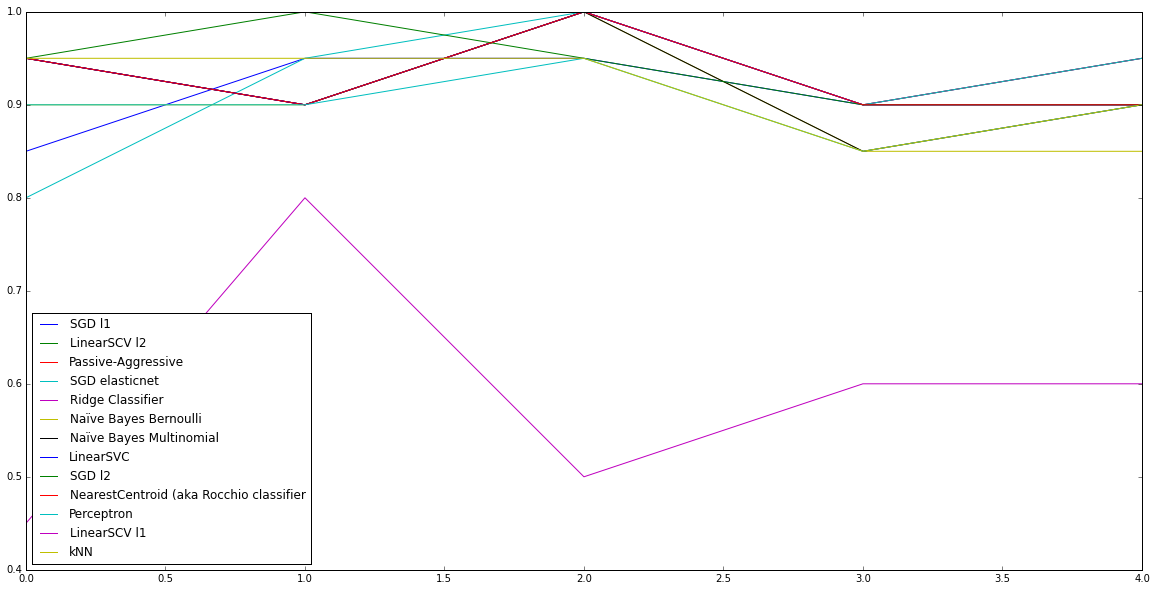

In [12]:
labelled_texts = [(fileid, corpus.raw(fileid)) for fileid in corpus.fileids()]
benchmark_svms(labelled_texts, 5, stoplist_vectorizer)

Those scores are pretty good – scores in the .93 range are indicating that over the course of 5 runs that modeller is correctly classifying texts in our test set 93% of the time (note that every time this test is run the results may vary).

### Supervised Classification of a Filtered Corpus

The modellers clearly work better on some runs than on others. We could hypothesize that where performance is weakest (where testing produces the lowest scores) may be where one or both of our Philosophy outliers _ThusSpakeZarathustra_ and _GameofLogic_ were included in the training set. One possibility is to remove those documents from our document set. We shouldn't make this move lightly as we may be sacrificing some potential for the classifier to find other philosophical outliers (border cases), but for now we can focus on reasonable steps to making the classifier as accurate as possible. Let's rerun the test after first filtering out our philosophical outliers.

Ordered averages:
Perceptron                                 0.978947
SGD l2                                     0.978947
SGD elasticnet                             0.978947
Naïve Bayes Multinomial                    0.968421
NearestCentroid (aka Rocchio classifier    0.947368
LinearSVC                                  0.947368
Ridge Classifier                           0.947368
Passive-Aggressive                         0.947368
LinearSCV l2                               0.947368
SGD l1                                     0.936842
Naïve Bayes Bernoulli                      0.852632
kNN                                        0.768421
LinearSCV l1                               0.736842
dtype: float64


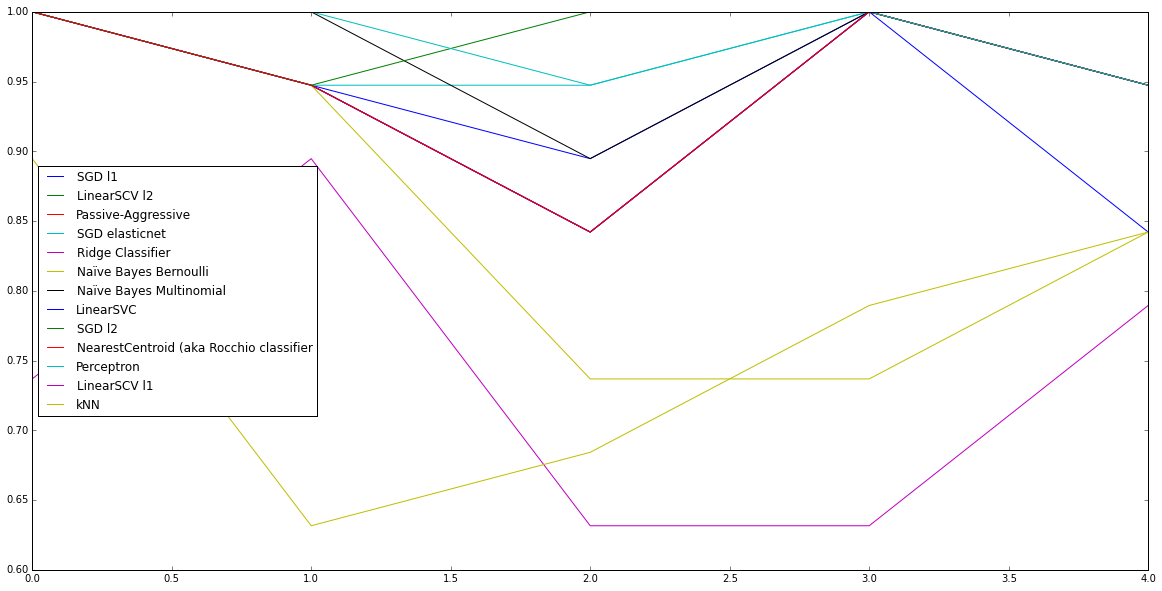

In [13]:
filtered_labelled_texts = [(fileid, text) for fileid, text in labelled_texts if "GameOfLogic" not in fileid and "ThusSpakeZarathustr" not in fileid]
benchmark_svms(filtered_labelled_texts, 5, stoplist_vectorizer)

These scores are definitely higher (the top scores shown here are close to 96% instead of 93% above), though it may benefit the lesser performing classifiers more than it benefits the best classifiers. There's still some variability, but that may be in part because of the random choice of "Other" texts that show some sign of being philosophical (based on relative frequencies).

### Supervised Classification Summary

The major take-aways from this work with supervised classification is that:

* we can achieve classification accuracy over 95% with our relatively small corpus
* it still helps to use stopwords
* we can improve results a bit by excluding some of our philosophical outliers
* there's a dizzying number of classifiers and parameters available for each classifier, this is an art…
* we would be justified, based on these limited tests, to choose the [Multinomial Naïve Bayes classifier](http://ogrisel.github.io/scikit-learn.org/sklearn-tutorial/modules/generated/sklearn.naive_bayes.MultinomialNB.html) for future work

## Next Steps

Now that we've done a bit of work to better understand the contours of our corpus and to fine-tune a classifier, we should be ready to train a classifier and try to identify philosophical texts in a much larger corpus. For best results, we can use the entire play corpus for training, minus the philosophical outliers. For simplicity, let's reproduce a stand-alone view of the needed code here:

In [14]:
import nltk
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB

# define the training corpus to use (while filtering out our Philosohpical ouliers)
data_dir = "../../data/philosophy"
corpus = nltk.corpus.reader.plaintext.PlaintextCorpusReader(data_dir+"/texts", ".*\.txt")
filtered_fileids = [fileid for fileid in corpus.fileids() if "GameOfLogic" not in fileid and "ThusSpakeZarathustr" not in fileid]

# create TF-IDF (actually elative frequencies) vectorizer
vectorizer = TfidfVectorizer(use_idf=False, stop_words=nltk.corpus.stopwords.words("english"), max_features=10000)
X_train = vectorizer.fit_transform([corpus.raw(fileid) for fileid in filtered_fileids])
categories = ["Philosophy" if "Philosophy" in fileid else "Other" for fileid in filtered_fileids]

# create a classiier
clf = MultinomialNB(alpha=.01)
clf.fit(X_train, categories)

# now we should be able to predict new instances given a frequencies vector
# (note that we're using TF-IDF values that may not correspond to the new corpus)
# clf.predict(X_test)

MultinomialNB(alpha=0.01, class_prior=None, fit_prior=True)

---

(CC-BY) By Stéfan Sinclair, Geoffrey Rockwell and the [Trace of Theory team](https://github.com/htrc/ACS-TT), last updated October 27, 2015.